In [1]:
import os
import cv2
from PIL import Image, ImageOps, ImageFilter
import numpy as np
from IPython.display import display
import random
import math
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from functools import partial
from collections import defaultdict
from datetime import datetime, timedelta, timezone
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
base_path = "/Users/nitesh/Downloads/test_images/"
image_paths = os.listdir(base_path)
print(len(image_paths))

1003


In [3]:
label_map = {1: "ticker", 0: "no_ticker"}
class2lable_map = {v: k for k, v in label_map.items()}

labels = []
pos = 0
neg = 0
total = len(image_paths)
for _path in image_paths:
    if _path.startswith("ticker_"):
        pos += 1
        labels.append(1)
    elif _path.startswith("no_ticker_"):
        neg += 1
        labels.append(0)

print((pos / total) * 100, (neg / total) * 100)

74.17746759720838 25.822532402791627


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    image_paths, labels, test_size=0.10, random_state=42, stratify=labels
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.10, random_state=42, stratify=y_train
)

train_data = []
for _path, label in zip(X_train, y_train):
    obj = {"path": os.path.join(base_path, _path), "label": label_map.get(label)}
    train_data.append(obj)

val_data = []
for _path, label in zip(X_val, y_val):
    obj = {"path": os.path.join(base_path, _path), "label": label_map.get(label)}
    val_data.append(obj)

test_data = []
for _path, label in zip(X_test, y_test):
    obj = {"path": os.path.join(base_path, _path), "label": label_map.get(label)}
    test_data.append(obj)

print(len(train_data),len(val_data), len(test_data))

811 91 101


## Preprocessing

In [6]:
## Utility function
def zoom_at(img, zoom=1, angle=0, coord=None):

    cy, cx = [i / 2 for i in img.shape] if coord is None else coord[::-1]

    rot_mat = cv2.getRotationMatrix2D((cx, cy), angle, zoom)
    result = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)

    return result

In [7]:
def preprocess_image_roi(image_path, save_path, label):
    """
    Preprocesses the image by applying various transformations to the ticker region of interest (ROI).

    Parameters:
    - image_path (str): Path to the input image.
    - save_path (str): Path to save the augmented images.
    - label (int): Class label (0 or 1).

    Returns:
    - None
    """
    # Load Image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found!")

    # Convert to Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Crop the bottom 8-10% (Focus on ticker region)
    h, w = gray.shape
    ticker_roi = gray[int(h * 0.92) :, :]

    save_filename = f"{os.path.splitext(os.path.basename(image_path))[0]}_orig.png"
    save_filepath = os.path.join(save_path, save_filename)
    cv2.imwrite(save_filepath, ticker_roi)

    # Define augmentations
    def mirror_image(img):
        return cv2.flip(img, 1)

    def blur_image(img):
        return cv2.GaussianBlur(img, (5, 5), 0)

    def rotate_image_clockwise(img):
        return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    
    def rotate_image_counterclockwise(img):
        return cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

    augmentations = [
        mirror_image,
        blur_image,
        rotate_image_clockwise,
        rotate_image_counterclockwise,
        lambda img: blur_image(mirror_image(img)),
        lambda img: rotate_image_clockwise(mirror_image(img)),
        lambda img: rotate_image_clockwise(blur_image(img)),
        lambda img: rotate_image_clockwise(blur_image(mirror_image(img))),
        lambda img: rotate_image_counterclockwise(mirror_image(img)),
        lambda img: rotate_image_counterclockwise(blur_image(img)),
        lambda img: rotate_image_counterclockwise(blur_image(mirror_image(img))),
    ]

    # Determine the number of augmentations based on the label
    num_augmentations = len(augmentations) if label == 0 else 4

    # Apply augmentations and save images
    for idx, aug in enumerate(random.choices(augmentations, k=num_augmentations)):
        augmented_img = aug(ticker_roi)
        save_filename = (
            f"{os.path.splitext(os.path.basename(image_path))[0]}_aug{idx}.png"
        )
        save_filepath = os.path.join(save_path, save_filename)
        cv2.imwrite(save_filepath, augmented_img)


# Preprocess and augment training data
save_path = "/Users/nitesh/Downloads/train_images/"
os.makedirs(save_path, exist_ok=True)

for data in train_data:
    preprocess_image_roi(data["path"], save_path, class2lable_map.get(data["label"]))

# Preprocess and augment validation data
save_path = "/Users/nitesh/Downloads/val_images/"
os.makedirs(save_path, exist_ok=True)

for data in val_data:
    preprocess_image_roi(data["path"], save_path, class2lable_map.get(data["label"]))

In [9]:
image = cv2.imread(save_path + "no_ticker_00071_orig.png")
print(image.shape)

image = cv2.imread(save_path + "no_ticker_00071_aug4.png")
print(image.shape)

image = cv2.imread(save_path + "no_ticker_00071_aug5.png")
print(image.shape)

(52, 640, 3)
(640, 52, 3)
(640, 52, 3)


## Training

In [11]:
class BalancedImageDataGenerator(Sequence):
    """
    A custom data generator that loads and preprocesses images while ensuring balanced batches.
    """

    def __init__(
        self, image_paths, batch_size=32, target_size=(224, 224), shuffle=True
    ):
        """
        Initializes the data generator.

        Args:
            image_paths (list): List of image file paths.
            batch_size (int): Number of images per batch.
            target_size (tuple): Desired image size (height, width).
            shuffle (bool): Whether to shuffle data after each epoch.
        """
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.classes = self._extract_classes()
        self.label_map = {1: "ticker", 0: "no_ticker"}
        self.class2label_map = {v: k for k, v in label_map.items()}
        self.labels = list(map(self.class2label_map.get, self.classes))
        self.class_indices = self._group_by_class()
        self.on_epoch_end()

    def _extract_classes(self):
        """
        Extracts class labels from image file names.

        Returns:
            list: List of class labels.
        """
        return [os.path.basename(path).rsplit("_", 2)[0] for path in self.image_paths]

    def _group_by_class(self):
        """
        Groups image paths by class labels.

        Returns:
            dict: Dictionary mapping class labels to image paths.
        """
        class_indices = defaultdict(list)
        for idx, label in enumerate(self.labels):
            class_indices[label].append(self.image_paths[idx])
        return class_indices

    def __len__(self):
        """
        Returns the number of batches per epoch.

        Returns:
            int: Number of batches per epoch.
        """
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def _load_and_resize_image(self, path):
        """
        Loads and resizes an image while preserving aspect ratio and padding.

        Args:
            path (str): Path to the image file.

        Returns:
            np.array: Preprocessed image array.
        """
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        old_h, old_w, _ = image.shape
        scale = min(self.target_size[0] / old_h, self.target_size[1] / old_w)
        new_h, new_w = int(old_h * scale), int(old_w * scale)
        resized = cv2.resize(image, (new_w, new_h))
        padded = np.full(
            (self.target_size[0], self.target_size[1], 3), 255, dtype=np.uint8
        )
        pad_h, pad_w = (self.target_size[0] - new_h) // 2, (
            self.target_size[1] - new_w
        ) // 2
        padded[pad_h : pad_h + new_h, pad_w : pad_w + new_w] = resized
        return padded / 255.0

    def __getitem__(self, index):
        """
        Generates one batch of data.

        Args:
            index (int): Batch index.

        Returns:
            tuple: Batch of images and corresponding labels.
        """
        batch_paths = []
        num_classes = len(self.class_indices)
        per_class = max(1, self.batch_size // num_classes)

        for label, paths in self.class_indices.items():
            sampled_paths = np.random.choice(
                paths, per_class, replace=len(paths) < per_class
            )
            batch_paths.extend(sampled_paths)

        if len(batch_paths) > self.batch_size:
            batch_paths = np.random.choice(batch_paths, self.batch_size, replace=False)

        batch_labels = [
            self.class2label_map.get(os.path.basename(p).rsplit("_", 2)[0])
            for p in batch_paths
        ]

        images = np.array([self._load_and_resize_image(p) for p in batch_paths])
        labels = np.array(batch_labels)
        return images, labels

    def on_epoch_end(self):
        """
        Shuffles data at the end of each epoch.
        """
        if self.shuffle:
            for key in self.class_indices:
                np.random.shuffle(self.class_indices[key])

In [12]:
# Testing data generator
image_paths = [
    os.path.join(save_path, _path)
    for _path in os.listdir(save_path)
    if _path.endswith(".png")
]

data_generator = BalancedImageDataGenerator(
    image_paths, batch_size=8, target_size=(224, 224), shuffle=True
)
images, labels = data_generator.__getitem__(10)
print(labels)

[0 0 0 0 1 1 1 1]


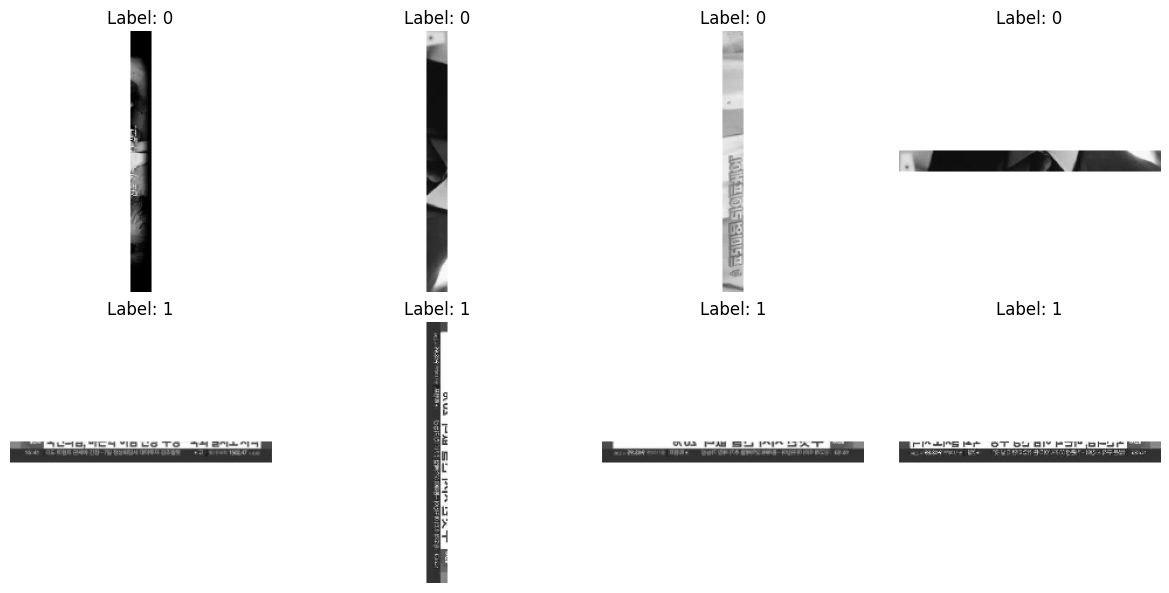

In [13]:
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i])  # Images are already normalized (0-1)
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [14]:
del data_generator

In [20]:
train_data_path = "/Users/nitesh/Downloads/train_images/"
val_data_path = "/Users/nitesh/Downloads/val_images/"

train_image_paths = [
    os.path.join(train_data_path, _path)
    for _path in os.listdir(train_data_path)
    if _path.endswith(".png")
]
train_labels = [
    1 if _path.split("/")[-1].startswith("ticker_") else 0 for _path in train_image_paths
]
val_image_paths = [
    os.path.join(val_data_path, _path)
    for _path in os.listdir(val_data_path)
    if _path.endswith(".png")
]
val_labels = [
    1 if _path.split("/")[-1].startswith("ticker_") else 0 for _path in val_image_paths
]

print(len(train_image_paths), len(val_image_paths))

train_data_generator = BalancedImageDataGenerator(
    train_image_paths, batch_size=64, target_size=(224, 224), shuffle=True
)

val_data_generator = BalancedImageDataGenerator(
    val_image_paths, batch_size=64, target_size=(224, 224), shuffle=True
)

5518 623


In [19]:
5518+623

6141

In [21]:
# Checking dataset balance
from collections import Counter
print(Counter(train_labels))
print(Counter(val_labels))

Counter({1: 3010, 0: 2508})
Counter({1: 335, 0: 288})


In [22]:
def build_cnn_model(input_shape=(224, 224, 3)):
    """
    Builds a 3-layer CNN model with regularization.

    Args:
        input_shape (tuple): Shape of input images.

    Returns:
        model (tf.keras.Model): Compiled CNN model.
    """
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Input(input_shape),
            tf.keras.layers.Conv2D(
                32,
                (3, 3),
                activation="relu",
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(
                64,
                (3, 3),
                activation="relu",
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(
                128,
                (3, 3),
                activation="relu",
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(
                128,
                activation="relu",
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(1, activation="sigmoid"),
        ]
    )

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [33]:
classifier = build_cnn_model()
classifier.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,497 (42.61 MB)

 Trainable params: 11,169,793 (42.61 MB)

 Non-trainable params: 704 (2.75 KB)

In [34]:
# Learning rate scheduler
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

scheduler = FactorScheduler(factor=0.9, stop_factor_lr=0.001, base_lr=0.1)

In [ ]:
run_id = datetime.now().strftime("%Y%m%d-%H%M%S")

log_dir = "logs/fit/" + run_id
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=11, restore_best_weights=True
)
lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


history = classifier.fit(
    train_data_generator,
    epochs=100,
    validation_data=val_data_generator,
    callbacks=[tensorboard_callback, early_stopping_callback, lr_scheduler_callback],
)

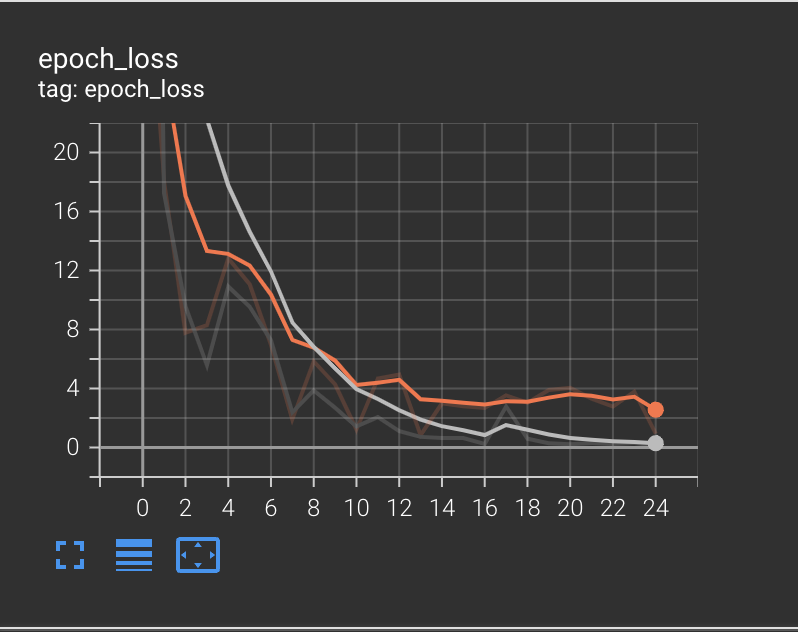

In [70]:
Image.open("/Users/nitesh/Desktop/CNN_training_tensorboard_loss.png")

In [ ]:
model_save_path = "saved_model/cnn_classifier" + run_id
classifier.export(model_save_path)
print(f"Model saved to {model_save_path}")

In [37]:
classifier.save(model_save_path + ".h5")

## Inference

In [38]:
# Uncomment below at to load model for inference
classifier = tf.keras.models.load_model("saved_model/cnn_classifier20250222-225918.h5")

In [39]:
target_size = (224,224)

def preprocess_image(image_path):
    # Load Image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found!")

    # Convert to Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Crop the bottom 8-10% (Focus on ticker region)
    h, w = gray.shape
    ticker_roi = gray[int(h * 0.92) :, :]
    
    # Save ROI image
    save_filename = f"{os.path.splitext(os.path.basename(image_path))[0]}_orig.png"
    save_filepath = os.path.join(save_path, save_filename)
    cv2.imwrite(save_filepath, ticker_roi)
    
    return save_filepath

def load_and_resize_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    old_h, old_w, _ = image.shape
    scale = min(target_size[0] / old_h, target_size[1] / old_w)
    new_h, new_w = int(old_h * scale), int(old_w * scale)
    resized = cv2.resize(image, (new_w, new_h))
    padded = np.full(
        (target_size[0], target_size[1], 3), 255, dtype=np.uint8
    )
    pad_h, pad_w = (target_size[0] - new_h) // 2, (
        target_size[1] - new_w
    ) // 2
    padded[pad_h : pad_h + new_h, pad_w : pad_w + new_w] = resized
    # print(padded.shape)
    return np.array(padded / 255.0)


In [40]:
true_labels = []
input_images = []
for obj in test_data:
    image_path = obj['path']
    label = class2lable_map.get(obj['label'])
    true_labels.append(label)
    
    roi_path = preprocess_image(image_path)
    input_img = load_and_resize_image(roi_path)
    input_images.append(input_img)

prediction = classifier.predict(np.array(input_images))
pred_labels = np.where(prediction.flatten() > 0.5, 1, 0) # TODO: Perform thresholding to tune this value

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


In [41]:
print(confusion_matrix(y_true=true_labels, y_pred=pred_labels))
print(classification_report(y_true=true_labels, y_pred=pred_labels))

[[26  0]
 [ 0 75]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00        75

    accuracy                           1.00       101
   macro avg       1.00      1.00      1.00       101
weighted avg       1.00      1.00      1.00       101



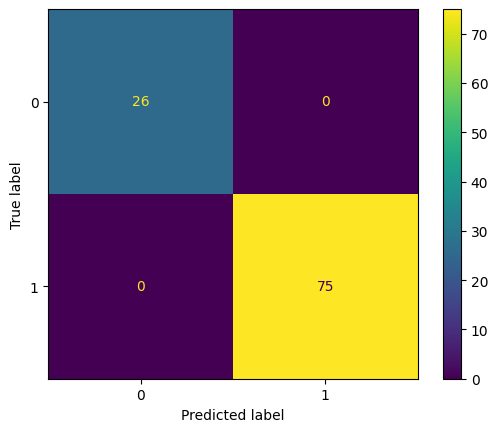

In [42]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true=true_labels, y_pred=pred_labels),
                              display_labels=[0, 1])
disp.plot()
plt.show()

## Transfer Learning using MobileNetV3

In [48]:
def preprocess_image_roi(image_path, save_path, label):
    """
    Preprocesses the image by applying various transformations to the Image.

    Parameters:
    - image_path (str): Path to the input image.
    - save_path (str): Path to save the augmented images.
    - label (int): Class label (0 or 1).

    Returns:
    - None
    """
    # Load Image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found!")

    save_filename = f"{os.path.splitext(os.path.basename(image_path))[0]}_orig.png"
    save_filepath = os.path.join(save_path, save_filename)
    cv2.imwrite(save_filepath, image)

    # Define augmentations
    def mirror_image(img):
        return cv2.flip(img, 1)

    def blur_image(img):
        return cv2.GaussianBlur(img, (15, 15), 0)

    def rotate_image_clockwise(img):
        return cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    
    def rotate_image_counterclockwise(img):
        return cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    def inverted_image(img):
        return cv2.rotate(img, cv2.ROTATE_180)

    augmentations = [
        mirror_image,
        blur_image,
        rotate_image_clockwise,
        rotate_image_counterclockwise,
        inverted_image,
        lambda img: blur_image(mirror_image(img)),
        lambda img: rotate_image_clockwise(mirror_image(img)),
        lambda img: rotate_image_clockwise(blur_image(img)),
        lambda img: rotate_image_clockwise(blur_image(mirror_image(img))),
        lambda img: rotate_image_counterclockwise(mirror_image(img)),
        lambda img: rotate_image_counterclockwise(blur_image(img)),
        lambda img: rotate_image_counterclockwise(blur_image(mirror_image(img))),
        lambda img: inverted_image(mirror_image(img)),
        lambda img: inverted_image(blur_image(img)),
        lambda img: inverted_image(blur_image(mirror_image(img))),
    ]

    # Determine the number of augmentations based on the label
    num_augmentations = len(augmentations) if label == 0 else 5

    # Apply augmentations and save images
    for idx, aug in enumerate(random.choices(augmentations, k=num_augmentations)):
        augmented_img = aug(image)
        save_filename = (
            f"{os.path.splitext(os.path.basename(image_path))[0]}_aug{idx}.png"
        )
        save_filepath = os.path.join(save_path, save_filename)
        cv2.imwrite(save_filepath, augmented_img)


# Preprocess and augment training data
save_path = "/Users/nitesh/Downloads/train_images/"
os.makedirs(save_path, exist_ok=True)

for data in train_data:
    preprocess_image_roi(data["path"], save_path, class2lable_map.get(data["label"]))

# Preprocess and augment validation data
save_path = "/Users/nitesh/Downloads/val_images/"
os.makedirs(save_path, exist_ok=True)

for data in val_data:
    preprocess_image_roi(data["path"], save_path, class2lable_map.get(data["label"]))

In [49]:
# Testing data generator
image_paths = [
    os.path.join(save_path, _path)
    for _path in os.listdir(save_path)
    if _path.endswith(".png")
]

data_generator = BalancedImageDataGenerator(
    image_paths, batch_size=8, target_size=(224, 224), shuffle=True
)
images, labels = data_generator.__getitem__(10)
print(labels)

[0 0 0 0 1 1 1 1]


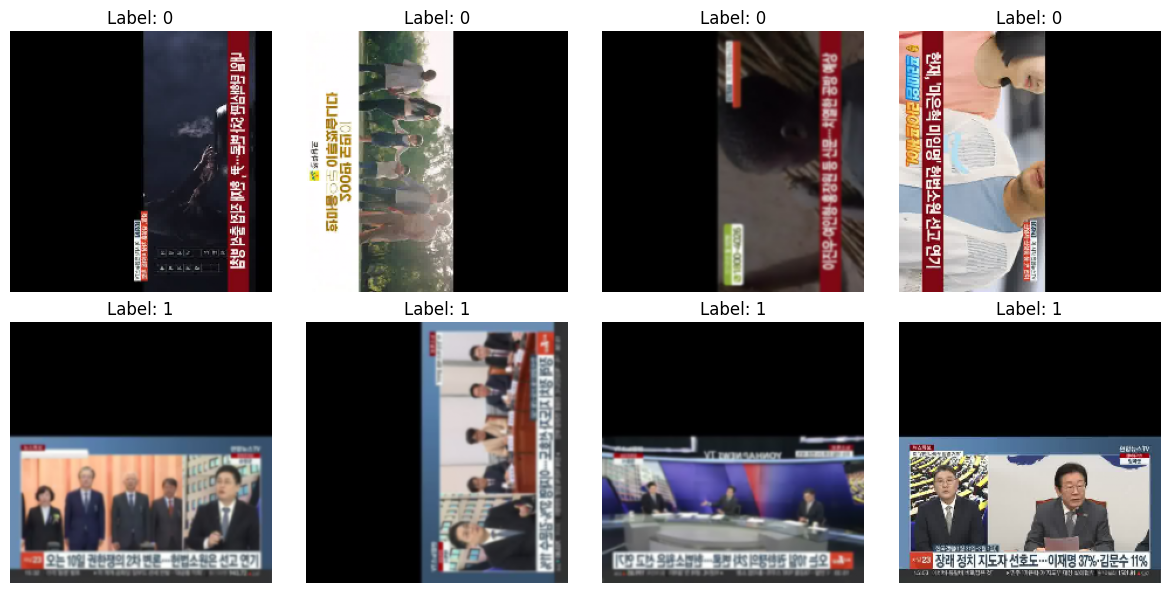

In [50]:
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i])  # Images are already normalized (0-1)
    plt.title(f"Label: {labels[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [51]:
del data_generator

In [52]:
train_data_path = "/Users/nitesh/Downloads/train_images/"
val_data_path = "/Users/nitesh/Downloads/val_images/"

train_image_paths = [
    os.path.join(train_data_path, _path)
    for _path in os.listdir(train_data_path)
    if _path.endswith(".png")
]
train_labels = [
    1 if _path.split("/")[-1].startswith("ticker_") else 0 for _path in train_image_paths
]
val_image_paths = [
    os.path.join(val_data_path, _path)
    for _path in os.listdir(val_data_path)
    if _path.endswith(".png")
]
val_labels = [
    1 if _path.split("/")[-1].startswith("ticker_") else 0 for _path in val_image_paths
]

print(len(train_image_paths), len(val_image_paths))

train_data_generator = BalancedImageDataGenerator(
    train_image_paths, batch_size=64, target_size=(224, 224), shuffle=True
)

val_data_generator = BalancedImageDataGenerator(
    val_image_paths, batch_size=64, target_size=(224, 224), shuffle=True
)

6956 786


In [53]:
6956+786

7742

In [54]:
# Checking dataset balance
from collections import Counter
print(Counter(train_labels))
print(Counter(val_labels))

Counter({1: 3612, 0: 3344})
Counter({1: 402, 0: 384})


In [58]:
base_model = tf.keras.applications.MobileNetV3Small(
    input_shape=(224, 224, 3), include_top=False, weights="imagenet"
)
base_model.trainable = False

In [59]:
classifier = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

classifier.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
classifier.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,013,105 (3.86 MB)

 Trainable params: 73,985 (289.00 KB)

 Non-trainable params: 939,120 (3.58 MB)

In [ ]:
scheduler = FactorScheduler(factor=0.9, stop_factor_lr=0.0001, base_lr=0.001)

run_id = datetime.now().strftime("%Y%m%d-%H%M%S")

log_dir = "logs/fit/" + run_id
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


history = classifier.fit(
    train_data_generator,
    epochs=100,
    validation_data=val_data_generator,
    callbacks=[tensorboard_callback, early_stopping_callback, lr_scheduler_callback],
)

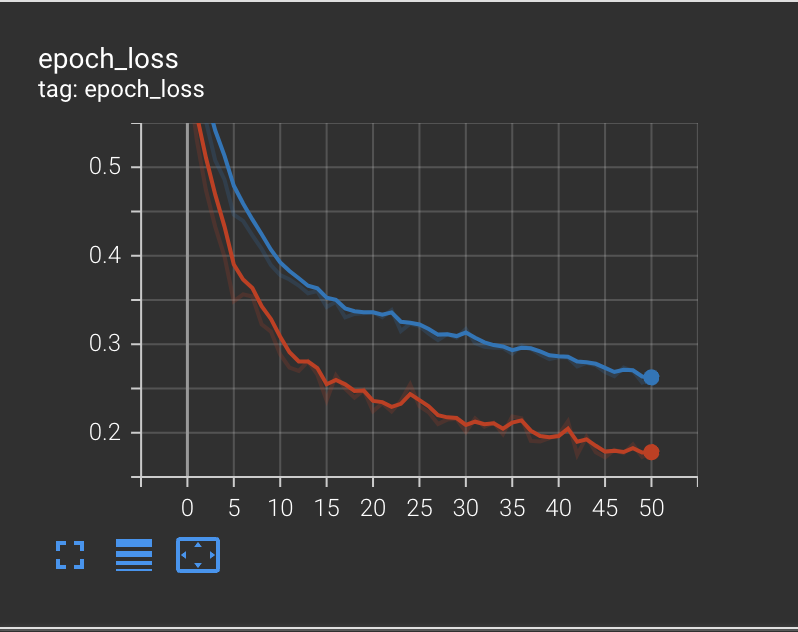

In [71]:
Image.open("/Users/nitesh/Desktop/MobileNet_training_tensorboard_loss.png")

In [61]:
model_save_path = "saved_model/mobilenet_classifier" + run_id + ".h5"
classifier.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to saved_model/mobilenet_classifier20250223-011947.h5


### Testing on hold-out set

In [62]:
target_size = (224,224)

def load_and_resize_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    old_h, old_w, _ = image.shape
    scale = min(target_size[0] / old_h, target_size[1] / old_w)
    new_h, new_w = int(old_h * scale), int(old_w * scale)
    resized = cv2.resize(image, (new_w, new_h))
    padded = np.full(
        (target_size[0], target_size[1], 3), 255, dtype=np.uint8
    )
    pad_h, pad_w = (target_size[0] - new_h) // 2, (
        target_size[1] - new_w
    ) // 2
    padded[pad_h : pad_h + new_h, pad_w : pad_w + new_w] = resized
    # print(padded.shape)
    return np.array(padded / 255.0)


In [63]:
true_labels = []
input_images = []
for obj in test_data:
    image_path = obj['path']
    label = class2lable_map.get(obj['label'])
    true_labels.append(label)
    
    input_img = load_and_resize_image(image_path)
    input_images.append(input_img)

prediction = classifier.predict(np.array(input_images))
pred_labels = np.where(prediction.flatten() > 0.5, 1, 0) # TODO: Perform thresholding to tune this value

2/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step WARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x305094540> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


In [64]:
print(confusion_matrix(y_true=true_labels, y_pred=pred_labels))
print(classification_report(y_true=true_labels, y_pred=pred_labels))

[[24  2]
 [ 0 75]]
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        26
           1       0.97      1.00      0.99        75

    accuracy                           0.98       101
   macro avg       0.99      0.96      0.97       101
weighted avg       0.98      0.98      0.98       101



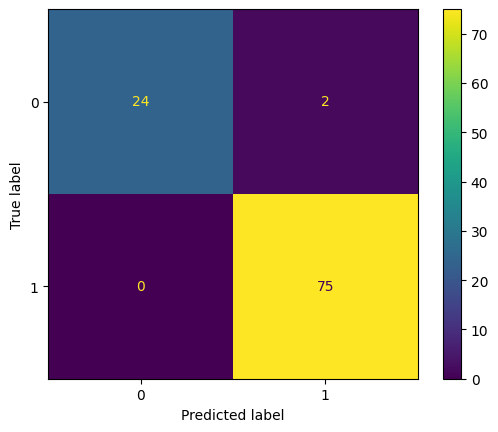

In [65]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true=true_labels, y_pred=pred_labels),
                              display_labels=[0, 1])
disp.plot()
plt.show()